In [11]:
# Imports
import pandas as pd
import numpy as np
import re
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import joblib
import os
from scipy.sparse import vstack

In [12]:
# Preprocessing Functions
def preprocess_text(text):
    """Preprocess single text string"""
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = re.sub(r'[^lower()\w\s]', '', text)
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

def process_batch(texts, vectorizer, mode='transform'):
    """Process a batch of texts using the vectorizer"""
    processed_texts = [preprocess_text(text) for text in tqdm(texts)]
    return vectorizer.fit_transform(processed_texts) if mode == 'fit_transform' else vectorizer.transform(processed_texts)

def load_and_process_in_batches(file_path, batch_size=10000):
    """Load and process CSV data in batches using a single vectorizer"""
    features_list = []
    labels_list = []
    vectorizer = None
    vocab = None

    for i, chunk in enumerate(pd.read_csv(file_path, encoding='latin-1', usecols=[0, 1], chunksize=batch_size)):
        y_batch = np.where(chunk.iloc[:, 0].str.lower() == 'spam', 1, 0)
        labels_list.append(y_batch)

        if i == 0:
            vectorizer = TfidfVectorizer(
                lowercase=True,
                strip_accents='unicode',
                max_features=10000,
                stop_words='english',
                min_df=5,
                max_df=0.95
            )
            X_batch = process_batch(chunk.iloc[:, 1], vectorizer, mode='fit_transform')
            vocab = vectorizer.get_feature_names_out()
        else:
            X_batch = process_batch(chunk.iloc[:, 1], vectorizer, mode='transform')

        features_list.append(X_batch)
        print(f"Processed batch {i + 1} of {len(chunk)} emails")

    X = vstack(features_list)
    y = np.concatenate(labels_list)
    return X, y, vocab

In [13]:
# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [ ]:
# Define paths
BASE_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(BASE_PATH, 'data', 'raw', 'spam_Emails_data.csv')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
os.makedirs(MODEL_PATH, exist_ok=True)

# Validate data file
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

print(f"Base path: {BASE_PATH}")
print(f"Data path: {DATA_PATH}")

Base path: d:\projects\SpamOrHam
Data path: d:\projects\SpamOrHam\data\raw\spam_Emails_data.csv


In [18]:
# Load and Process Data
print("Loading dataset in batches...")
X, y, vocab = load_and_process_in_batches(DATA_PATH, batch_size=10000)


Loading dataset in batches...


100%|██████████| 10000/10000 [01:11<00:00, 139.86it/s]


Processed batch 1 of 10000 emails


100%|██████████| 10000/10000 [00:44<00:00, 226.65it/s]


Processed batch 2 of 10000 emails


100%|██████████| 10000/10000 [00:52<00:00, 189.77it/s]


Processed batch 3 of 10000 emails


100%|██████████| 10000/10000 [00:43<00:00, 230.72it/s]


Processed batch 4 of 10000 emails


100%|██████████| 10000/10000 [00:46<00:00, 216.75it/s]


Processed batch 5 of 10000 emails


100%|██████████| 10000/10000 [00:43<00:00, 228.74it/s]


Processed batch 6 of 10000 emails


100%|██████████| 10000/10000 [00:40<00:00, 247.47it/s]


Processed batch 7 of 10000 emails


100%|██████████| 10000/10000 [00:39<00:00, 255.54it/s]


Processed batch 8 of 10000 emails


100%|██████████| 10000/10000 [00:39<00:00, 251.96it/s]


Processed batch 9 of 10000 emails


100%|██████████| 10000/10000 [00:41<00:00, 240.05it/s]


Processed batch 10 of 10000 emails


100%|██████████| 10000/10000 [00:42<00:00, 234.06it/s]


Processed batch 11 of 10000 emails


100%|██████████| 10000/10000 [00:39<00:00, 251.69it/s]


Processed batch 12 of 10000 emails


100%|██████████| 10000/10000 [00:40<00:00, 248.09it/s]


Processed batch 13 of 10000 emails


100%|██████████| 10000/10000 [00:40<00:00, 245.11it/s]


Processed batch 14 of 10000 emails


100%|██████████| 10000/10000 [00:42<00:00, 235.13it/s]


Processed batch 15 of 10000 emails


100%|██████████| 10000/10000 [00:41<00:00, 238.61it/s]


Processed batch 16 of 10000 emails


100%|██████████| 10000/10000 [00:41<00:00, 241.89it/s]


Processed batch 17 of 10000 emails


100%|██████████| 10000/10000 [00:40<00:00, 246.33it/s]


Processed batch 18 of 10000 emails


100%|██████████| 10000/10000 [00:36<00:00, 271.97it/s]


Processed batch 19 of 10000 emails


100%|██████████| 3852/3852 [00:13<00:00, 290.91it/s]


Processed batch 20 of 3852 emails


In [19]:
# Train the Model
print("\nTraining model...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearSVC(random_state=42, max_iter=1000, tol=1e-4, dual=False, C=1.0)
model.fit(X_train, y_train)


Training model...


LinearSVC(dual=False, random_state=42)

In [20]:

# Evaluate Model
print("\nModel evaluation:")
print(f"Training accuracy: {model.score(X_train, y_train):.4f}")
print(f"Testing accuracy: {model.score(X_test, y_test):.4f}")


Model evaluation:
Training accuracy: 0.9903
Testing accuracy: 0.9803


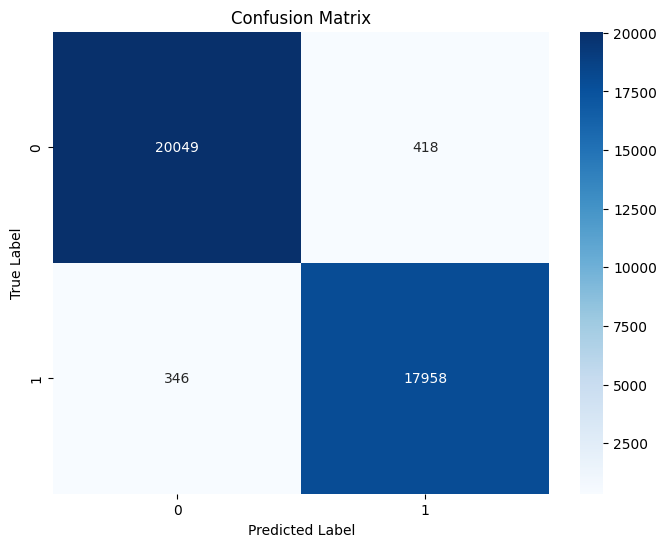


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     20467
           1       0.98      0.98      0.98     18304

    accuracy                           0.98     38771
   macro avg       0.98      0.98      0.98     38771
weighted avg       0.98      0.98      0.98     38771



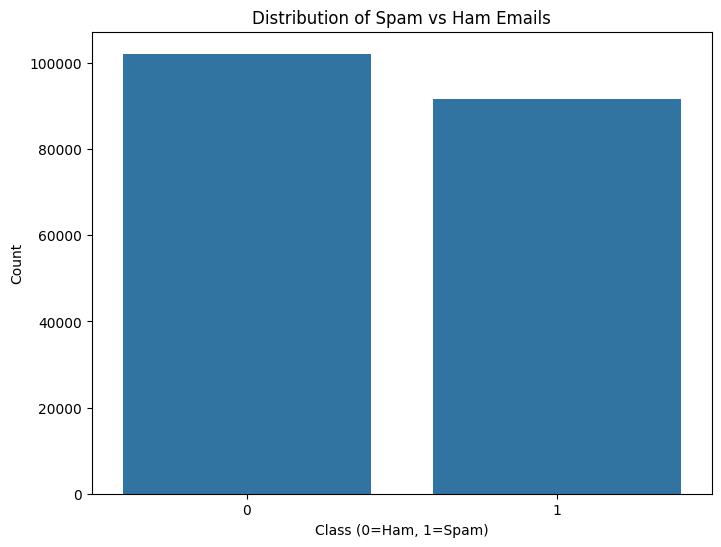

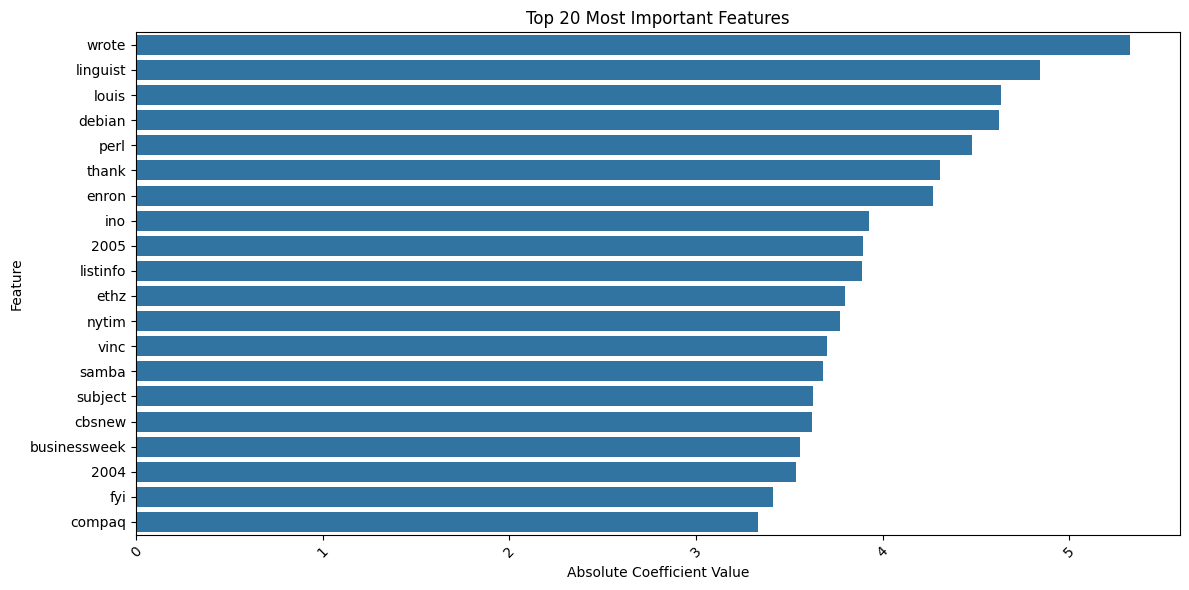

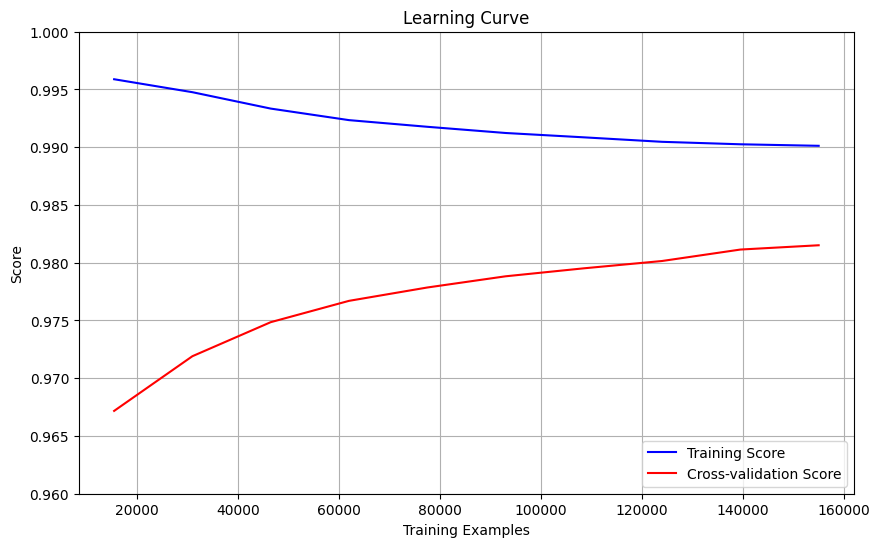

In [28]:
# Add after the model evaluation cell
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(MODEL_PATH, 'confusion_matrix.png'))
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, model.predict(X_test)))

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Spam vs Ham Emails')
plt.xlabel('Class (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.savefig(os.path.join(MODEL_PATH, 'class_distribution.png'))
plt.show()

# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': vocab,
    'importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'feature_importance.png'))
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    LinearSVC(random_state=42, max_iter=1000),
    X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training set scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for cross-validation set scores
cv_scores_mean = np.mean(test_scores, axis=1)
cv_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'b-', label='Training Score')
plt.plot(train_sizes, cv_scores_mean, 'r-', label='Cross-validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.grid(True)
plt.legend(loc='lower right')
plt.ylim(0.96, 1.0)  # Adjust these values to zoom in on the range of interest

plt.savefig(os.path.join(MODEL_PATH, 'learning_curve.png'))
plt.show()

In [22]:

# Save Model and Vocabulary
print("\nSaving model and vocabulary...")
joblib.dump(model, os.path.join(MODEL_PATH, 'spam_classifier.pkl'))
joblib.dump(vocab, os.path.join(MODEL_PATH, 'vocabulary.pkl'))
print("Training complete!")


Saving model and vocabulary...
Training complete!
